# Galaxy builder data aggregation

This notebook is a playground to develop the aggregation scripts for galaxy builder.

## Spiral arms

Want to cluster spiral arm points to identify individual arms, and then fit a smoothed spline to those points to provide arm number $m(r)$ and pitch-angle $\Psi(r)$ as functions of (deprojected) radius. Proposed steps as follows:

1) Group points (lines? Retains more data) into underlying drawn arm
2) fit spline

### Generation of clean data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FloatProgress
from IPython.display import display

np.random.seed(0)

In [2]:
def logSpiral(a, b, deltaTheta=0):
    return lambda t: np.transpose(np.concatenate((
        (a*np.cos(t+deltaTheta)*np.exp(b*t)).reshape(1, -1),
        (a*np.sin(t+deltaTheta)*np.exp(b*t)).reshape(1, -1)
    )))

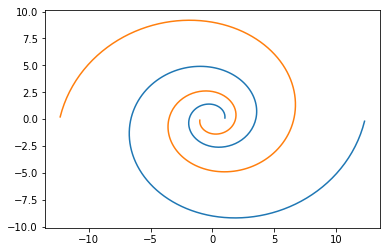

In [3]:
sFunc1 = logSpiral(1, 0.2)
sFunc2 = logSpiral(1, 0.2, deltaTheta=np.pi)
spiral1 = sFunc1(np.arange(0.1, 4*np.pi, 0.05))
spiral2 = sFunc2(np.arange(0.1, 4*np.pi, 0.05))
plt.plot(spiral1[:, 0], spiral1[:, 1])
plt.plot(spiral2[:, 0], spiral2[:, 1])

## Making some noise
Now we have our base spirals, we generate (slightly) noisy data by perturbing the vertices

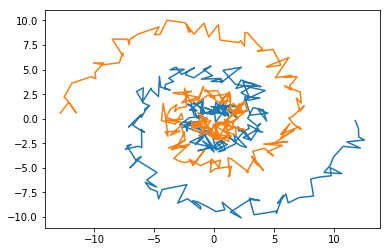

In [4]:
def makeNoisySpiral(s):
    return s + (2 * np.random.random(s.shape) - [1, 1])

noisy1 = makeNoisySpiral(spiral1)
noisy2 = makeNoisySpiral(spiral2)

plt.plot(noisy1[:,0], noisy1[:,1])
plt.plot(noisy2[:,0], noisy2[:,1])

And now do that a bunch of times

Shape of fake classifications: (20, 250, 2)


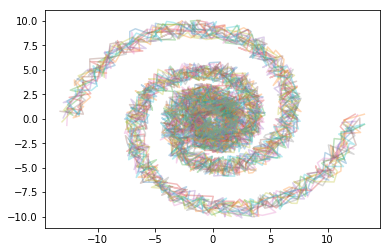

In [5]:
fakeClassifications = np.concatenate([
    np.concatenate((makeNoisySpiral(spiral1).reshape(1, -1), makeNoisySpiral(spiral2).reshape(1, -1))).reshape(1, 2, spiral2.shape[0], -1)
    for i in range(10)
])
fakeS1s = np.array([makeNoisySpiral(spiral1) for i in range(10)])
fakeS2s = np.array([makeNoisySpiral(spiral2) for i in range(10)])

fakeClassifications = np.concatenate((fakeS1s, fakeS2s))

print('Shape of fake classifications:', fakeClassifications.shape)
# Data structure:
#     fakeClassifications = Array of 
#         arms = Array of 
#             points = Array of 
#                 x = float
#                 y = float

armLabelsTrue = np.concatenate((
    np.zeros(int(len(fakeClassifications) / 2)),
    np.ones(int(len(fakeClassifications) / 2))
))

for arm in fakeClassifications:
    p = plt.plot(arm[:, 0], arm[:, 1], alpha=0.3)
    color = p[0].get_color()

### Getting messy

Sometimes people will have drawn spirals inside out, missed one or only drawn a part of one, which we should account for in our test data

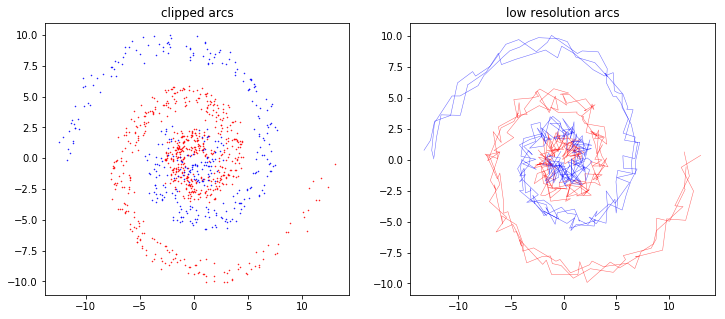

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
reverseSpiral = lambda s: s[::-1]
def clipSpiral(s):
    l = len(s)
    splitIndex = np.random.randint(l)
    sSize = np.random.randint(10, l/2+1)
    return s[max(splitIndex - sSize, 0):min(splitIndex + sSize, l)]

clippedClassifications = (
    [clipSpiral(makeNoisySpiral(spiral1)) for i in range(3)] +
    [clipSpiral(makeNoisySpiral(spiral2)) for i in range(3)]
)
clippedLabels = np.concatenate((np.zeros(3), np.ones(3)))

mediumRes = makeNoisySpiral(sFunc1(np.linspace(0.1, 4*np.pi, 125)))
lowRes = makeNoisySpiral(sFunc1(np.arange(0.1, 4*np.pi, 70)))

lowResClassifications = (
    [makeNoisySpiral(sFunc1(np.linspace(0.1, 4*np.pi, 100))) for i in range(3)] +  # medium resolution
    [makeNoisySpiral(sFunc2(np.linspace(0.1, 4*np.pi, 100))) for i in range(3)] +
    [makeNoisySpiral(sFunc1(np.linspace(0.1, 4*np.pi, 40))) for i in range(3)] +  # low resolution
    [makeNoisySpiral(sFunc2(np.linspace(0.1, 4*np.pi, 40))) for i in range(3)]
)
lowResLabels = np.concatenate((np.zeros(3), np.ones(3), np.zeros(3), np.ones(3)))

reversedClassifications = (
    [reverseSpiral(makeNoisySpiral(spiral1)) for i in range(3)] +
    [reverseSpiral(makeNoisySpiral(spiral2)) for i in range(3)]
)
reversedLabels = np.concatenate((np.zeros(3), np.ones(3)))

ax[0].set_title('clipped arcs')
for arc, label in zip(clippedClassifications, clippedLabels):
    c = 'b' if label else 'r'
    ax[0].plot(arc[:,0],arc[:,1], '.', c=c, markersize=1)

ax[1].set_title('low resolution arcs')
for arc, label in zip(lowResClassifications, clippedLabels):
    c = 'b' if label else 'r'
    ax[1].plot(arc[:,0],arc[:,1], '-', c=c, linewidth=0.5, alpha=0.6)

fakeClassificationsComplete = np.array(
    [i for i in fakeClassifications] +
    clippedClassifications +
    lowResClassifications +
    reversedClassifications
)

armLabelsTrueComplete = np.concatenate((
    armLabelsTrue,
    clippedLabels,
    lowResLabels,
    reversedLabels
))

We then randomly shuffle the classifications for good measure!

In [7]:
# shuffleIndexes = np.random.choice(len(fakeClassificationsComplete), len(fakeClassificationsComplete))
# fakeClassificationsComplete = fakeClassificationsComplete[shuffleIndexes]
# armLabelsTrueComplete = armLabelsTrueComplete[shuffleIndexes]

And then make sure the "gold standard" labels are still correct:

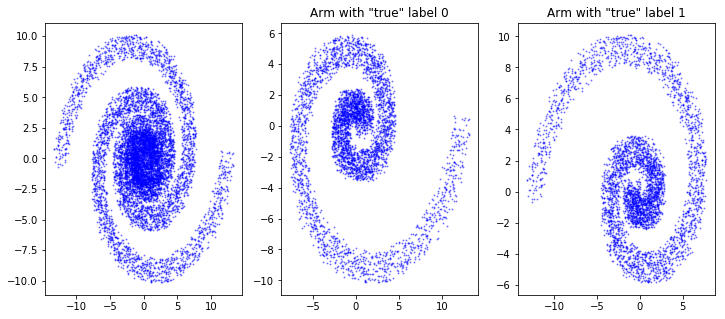

In [8]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 5))
for i, label in enumerate(np.unique(armLabelsTrueComplete)):
    for arm in fakeClassificationsComplete[armLabelsTrueComplete == label]:
        ax[0].plot(arm[:, 0], arm[:, 1], 'b.', markersize=2, alpha=0.4)
        ax[i+1].plot(arm[:, 0], arm[:, 1], 'b.', markersize=2, alpha=0.4)
        
ax[1].set_title('Arm with "true" label 0')
ax[2].set_title('Arm with "true" label 1')

Okay, now we have something that could (maybe) represent a load of classifications. Time to move on to the grouping

## Classification grouping

We will make use of the `DBSCAN` clustering algorithm to try and group spirals


In [9]:
# Imports
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

Define a distance metric to identify how similar two arms are. The algorithm iterates through each arm and finds the nearest point on the other arm (either a vertex or on an edge). It then sums these nearest neighbours to provide a total "separation"

In [10]:
# function to get distance from a point (y) to a line connected by two vertices (p1, p2)
# from https://stackoverflow.com/questions/849211/shortest-distance-between-a-point-and-a-line-segment

def distance2(a, b):
    return (a[0]-b[0])**2 + (a[1]-b[1])**2
    
def dot(a, b):
    return a[0]*b[0] + a[1]*b[1]

def minimum_distance(p, v, w):
    # Return minimum distance between line segment vw and point p
    l2 = distance2(v, w);  # i.e. |w-v|^2 -  avoid a sqrt
    if l2 == 0.0: return np.sqrt(distance2(p, v));   # v == w case
    # Consider the line extending the segment, parameterized as v + t (w - v).
    # We find projection of point p onto the line. 
    # It falls where t = [(p-v) . (w-v)] / |w-v|^2
    # We clamp t from [0,1] to handle points outside the segment vw.
    t = max(0.0, min(1.0, dot(p - v, w - v) / l2))
    projection = v + t * (w - v)  # Projection falls on the segment
    return np.sqrt(distance2(p, projection))

def arcDistance(a, b):
    s1, s2 = 0, 0
    # add the minimum distance from each vertex to the other arm to a running total
    for point in a:
        s1 += min(minimum_distance(point, b[i], b[i+1]) for i in range(len(b)-1))
    # and for the other arm
    for point in b:
        s2 += min(minimum_distance(point, a[i], a[i+1]) for i in range(len(a)-1))
    # return the minimum distance 
    return (s1/len(a) + s2/len(b))

def aD2(a, b):
    return arcDistance(a.reshape(-1, 2), b.reshape(-1, 2))

# test by getting distance from (0,0) to [(1, -1), (1, 1)]
yCheck, p1Check, p2Check = np.array([0,0]), np.array([1, -1]), np.array([1, 1])
print('Passed test' if minimum_distance(yCheck, p1Check, p2Check) == 1.0 else 'Failed test :(')



# %lprun -f getDistance arcDistanceNew(noisy1, noisy2)  # detailed profiling
# %timeit arcDistance(noisy1, noisy2)

Passed test


It's a pretty painful running speed, can we speed it up using the magic of numpy..?

In [11]:
# calculate dot(a) of a(n,2), b(n,2): np.add.reduce(b1 * b2, axis=1)
# calucalte norm(a) of a(n,2), b(n,2): np.add.reduce((a-b)**2, axis=1)
def calcT(a):
    b1 = a[:, 0, :] - a[:, 1, :]
    b2 = a[:, 2, :] - a[:, 1, :]
    dots = np.add.reduce(b1 * b2, axis=1)
    l2 = np.add.reduce((a[:, 1] - a[:, 2])**2, axis=1)
    out = np.clip(dots / l2, 0, 1)
    return out

def getDiff(t, a):
    projection = a[:,1,:] + np.repeat(t.reshape(-1, 1), 2, axis=1) * (a[:,2,:] - a[:,1,:])
    out = np.add.reduce((a[:,0,:]-projection) * (a[:,0,:]-projection), axis=1)
    return np.sqrt(np.min(out))

vCalcT = np.vectorize(calcT, signature='(a,b,c)->(a)')
vGetDiff = np.vectorize(getDiff, signature='(a),(a,b,c)->()')

def minimum_distance(a, b):
    d = 0
#     print(np.roll(b, 1, axis=0))
    m = np.zeros((a.shape[0], b.shape[0]-1, 3, 2))
    m[:, :, 0, :] = np.transpose(np.tile(a, [m.shape[1]+1, 1, 1]), axes=[1, 0, 2])[:, :-1, :]
    m[:, :, 1, :] = np.tile(b, [a.shape[0], 1, 1])[:, :-1, :]
    m[:, :, 2, :] = np.tile(np.roll(b, -1, axis=0), [a.shape[0], 1, 1])[:, :-1, :]
    t = vCalcT(np.array(m))
    return np.sum(vGetDiff(t, m))/a.shape[0]
    
def arcDistanceFast(a, b):
    return (
        minimum_distance(a, b) +
        minimum_distance(b, a)
    )

# %timeit arcDistanceFast(noisy1, noisy2)

Much better!! Only takes a fraction of the time to run (and hopefully scales better too)

We verify this produces low-distances even for arms with variable resolution

Measured distance:
High to medium: 0.5497617652449094 
High to low: 0.786211095947829


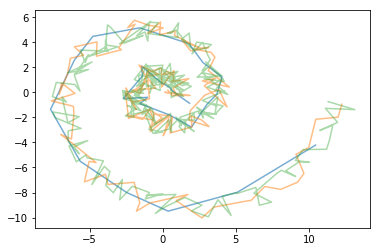

In [12]:
highRes = makeNoisySpiral(sFunc1(np.arange(0.1, 4*np.pi, 0.05)))
mediumRes = makeNoisySpiral(sFunc1(np.arange(0.1, 4*np.pi, 0.1)))
lowRes = makeNoisySpiral(sFunc1(np.arange(0.1, 4*np.pi, 0.5)))
plt.plot(lowRes[:, 0], lowRes[:, 1], alpha=0.6)
plt.plot(mediumRes[:, 0], mediumRes[:, 1], alpha=0.5)
plt.plot(highRes[:, 0], highRes[:, 1], alpha=0.4)
print(
    'Measured distance:\nHigh to medium:', arcDistanceFast(highRes, mediumRes),
    '\nHigh to low:', arcDistanceFast(highRes, lowRes)
)


Awesome, we'll also create labels to test the accuracy of clustering

### ML Clustering to identify arms

`sklearn` `DBSCAN` requires that the input vector be a two-dimensional array, however since we have introduced arms of varying lengths we can't simply make a nice numpy array. Instead we pass in a precalculated distance array to be used as a metric.



Using saved distances


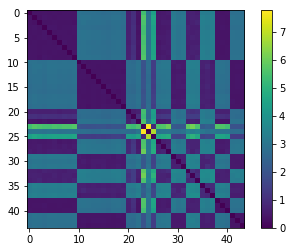

In [13]:
import time
def calculateDistanceMatrix(cls):
    n = len(cls)**2/2 - len(cls)/2
    f = FloatProgress(min=0, max=n)
    display(f)
    distances = np.zeros((len(cls), len(cls)))
    t0 = time.time()
    for i in range(len(cls)):
        for j in range(i+1, len(cls)):
            f.value += 1
            distances[i,j] = arcDistanceFast(cls[i], cls[j])
    distances += np.transpose(distances)
    return distances

try:
    with open('fakeClassificationsComplete.npy', 'rb') as f:
        s = np.load(f)
    if all(len(i) == len(j) and np.sum(i-j) == 0 for i,j in zip(fakeClassificationsComplete, s)):
        print('Using saved distances')
        with open('distances.npy', 'rb') as f:
            distances = np.load(f)
    else:
        print('Spirals differ, recalculating distances')
        t0 = time.time()
        distances = calculateDistanceMatrix(fakeClassificationsComplete)
        print(time.time() - t0)
        with open('fakeClassificationsComplete.npy', 'wb') as f:
            np.save(f, fakeClassificationsComplete)
        with open('distances.npy', 'wb') as f:
            np.save(f, distances)

except FileNotFoundError:
    print('Couldn\'t locate required files, recalculating distances')
    t0 = time.time()
    distances = calculateDistanceMatrix(fakeClassificationsComplete)
    print(time.time() - t0)
    with open('fakeClassificationsComplete.npy', 'wb') as f:
        np.save(f, fakeClassificationsComplete)
    with open('distances.npy', 'wb') as f:
        np.save(f, distances)
plt.imshow(distances)
plt.colorbar()

We can then initialise a `DBSCAN` fitter with a maximum neighbour distance of 100 (could be higher, will depend on spiral pitch angle / number of arms), and a minimum number of samples for a given clump to be called an arm (in this case 5). We also provide the metric.

Once the object is initialised we can start the fit! Extracted information is printed below.

In [14]:
# initialise fitter and fit! 
db = DBSCAN(eps=1, min_samples=5, metric='precomputed', n_jobs=-1, algorithm='brute')
db.fit(distances)

# Obtain clustering results
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
armLabels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(armLabels)) - (1 if -1 in armLabels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(armLabelsTrueComplete, armLabels))
print("Completeness: %0.3f" % metrics.completeness_score(armLabelsTrueComplete, armLabels))
print("V-measure: %0.3f" % metrics.v_measure_score(armLabelsTrueComplete, armLabels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(armLabelsTrueComplete, armLabels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(armLabelsTrueComplete, armLabels))

Estimated number of clusters: 2
Homogeneity: 1.000
Completeness: 0.777
V-measure: 0.874
Adjusted Rand Index: 0.879
Adjusted Mutual Information: 0.770


### Well it's something...?

The algorithm excludes short arms, even if they fall in the same position as longer ones. This is a neccessary (maybe) tradeoff to exclude cases where someone has drawn both arms in the same polygon.

The extracted spiral arms can be seen below.

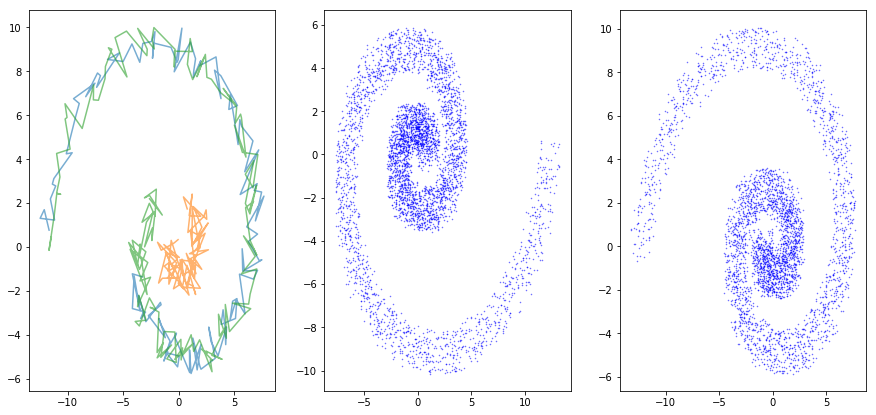

In [15]:
fig, ax = plt.subplots(ncols=len(np.unique(armLabels)), figsize=(15, 7))
for i, label in enumerate(np.unique(armLabels)):
    identified = fakeClassificationsComplete[np.where(armLabels == label)]
    for arm in identified:
        ax[i].plot(arm[:, 0], arm[:, 1], ('b.' if i > 0 else ''), markersize=1, alpha=0.6)

## Recovering spiral information

We now have a point cloud representing the spiral. From here we could make use of the centre of the drawn disk / some other marked centre and fit a log spiral back to the data.

However this introduces biases - namely that the pitch angle is constant with radius (it isn't in general), the centre has been marked correctly and that we have correctly deprojected the galaxy (and that it isn't actually an ellipse).

For this reason I will instead make use of a smoothed spline fit, and then introduce the 2nd and 3rd biases again when I choose a center to measure pitch angle from!

In [16]:
from scipy.interpolate import UnivariateSpline

def rThetaFromXY(x, y, mux=0, muy=0):
    return np.sqrt((x - mux)**2 + (y - muy)**2), np.arctan2((y - muy),(x - mux))

def xyFromRTheta(r, theta, mux=0, muy=0):
    return mux + r*np.cos(theta), muy + r*np.sin(theta)

Worth noting that $\theta \in [-\pi, \pi]$

The main problem encountered now is that of correctly performing a spline fit. Rather than fitting a spline to each point identified as being part of an arm, we'll try fitting a spline to each arm identified in the group, and then aggregate these splines.

And so our resulting spline fit looks as follows!

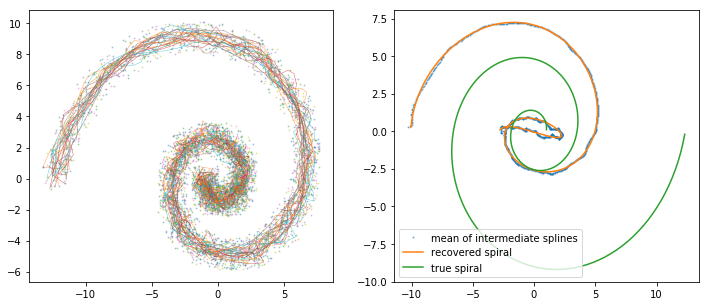

In [17]:
fig,ax = plt.subplots(ncols=2, figsize=(12, 5))
xFuncs = []
yFuncs = []
label = 1
for arm in fakeClassificationsComplete[armLabelsTrueComplete == label]:
    t = np.linspace(0, 1, arm.shape[0])
    sx = UnivariateSpline(t, arm[:,0], s=arm.shape[0]/5, k=5, ext='raise')
    sy = UnivariateSpline(t, arm[:,1], s=arm.shape[0]/5, k=5, ext='raise')
    xFuncs += [sx]
    yFuncs += [sy]
    ax[0].plot(arm[:,0], arm[:,1], '.', markersize=2, alpha=0.3)
    ax[0].plot(sx(t), sy(t), linewidth=0.5, alpha=0.7)

t = np.linspace(0, 1, 1000)

aggregateX = [np.mean([f(i) for f in xFuncs]) for i in t]
aggregateY = [np.mean([f(i) for f in yFuncs]) for i in t]

Sx = UnivariateSpline(t, aggregateX, s=5, k=5)
Sy = UnivariateSpline(t, aggregateY, s=5, k=5)

ax[1].plot(aggregateX, aggregateY, '.', markersize=2, alpha=0.5, label='mean of intermediate splines')
ax[1].plot(Sx(t), Sy(t), label='recovered spiral')
ax[1].plot(spiral1[:,0], spiral1[:, 1], label='true spiral')
ax[1].legend()

Ah. Not good.

What's going wrong here is that we've parametrised $x(t)$ and $y(t)$, and then aggregated along $t$ without considering that some spirals have been reversed, and others decimated/clipped!

Flipping each line by whether the mean radius of the first half is lower than the mean radius of the second half (for deprojected spirals, and with a prior on the galaxy centre) would possibly fix the reversed arm issue, but not the other problems...

## Another tack

Okay, can we use a ML clusterer to group the points along the spiral, then sort each group by its average radius, and  inside each group by ascending $\theta$? Then we fit a smoothed spline to the (hopefully ordered) points as a whole!

We need to check if a group's theta overflows from $+\pi$ to $-\pi$, and correct accordingly. For tightly wound groups (where we go past $-\pi$ twice), this will break. Suggestions welcome!!

In [18]:
from sklearn.cluster import SpectralClustering

In [25]:
%%time
pointCloud = np.array([
    point for arm in fakeClassificationsComplete[armLabelsTrueComplete == label] 
    for point in arm
])
sC = SpectralClustering(n_clusters=20).fit(pointCloud)

CPU times: user 6.46 s, sys: 498 ms, total: 6.96 s
Wall time: 5.19 s


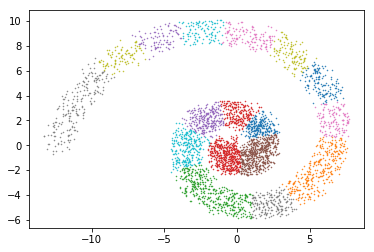

In [21]:
for sublabel in np.unique(sC.labels_):
    plt.plot(
        pointCloud[sC.labels_ == sublabel, 0], pointCloud[sC.labels_ == sublabel, 1],
        '.', markersize=1,
        label=sublabel
    )

Looks promising!!

In [22]:
sortedBatches = []
means = np.zeros((len(np.unique(sC.labels_)), 2))
count = 0
for i, sublabel in enumerate(np.unique(sC.labels_)):
    mask = sC.labels_ == sublabel
    r, theta = rThetaFromXY(pointCloud[mask, 0], pointCloud[mask, 1])
    if min(theta) < -3*np.pi/4 and 3* max(theta) > np.pi/4:
        theta[theta < -np.pi / 2] += 2*np.pi
    args = np.argsort(theta)
    sortedBatches.append(pointCloud[mask][args])
    count += r.shape[0]
    means[i] = [np.mean(pointCloud[mask, 0]), np.mean(pointCloud[mask, 1])]
means = np.array(means)

The resulting (mostly) ordered points are therefore...

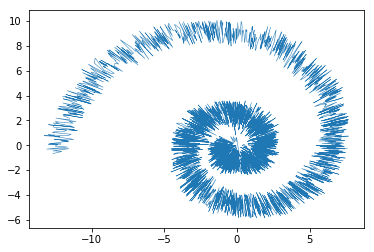

In [23]:
r, theta = rThetaFromXY(means[:, 0], means[:, 1])
a = np.argsort(r)
result = np.array([p for i in a for p in sortedBatches[i]])
# plt.plot(means[a, 0], means[a, 1])
plt.plot(result[:, 0], result[:, 1], linewidth=0.5)


## The final spline

And now for the final step, fitting a parametrised spline to the ordered points!

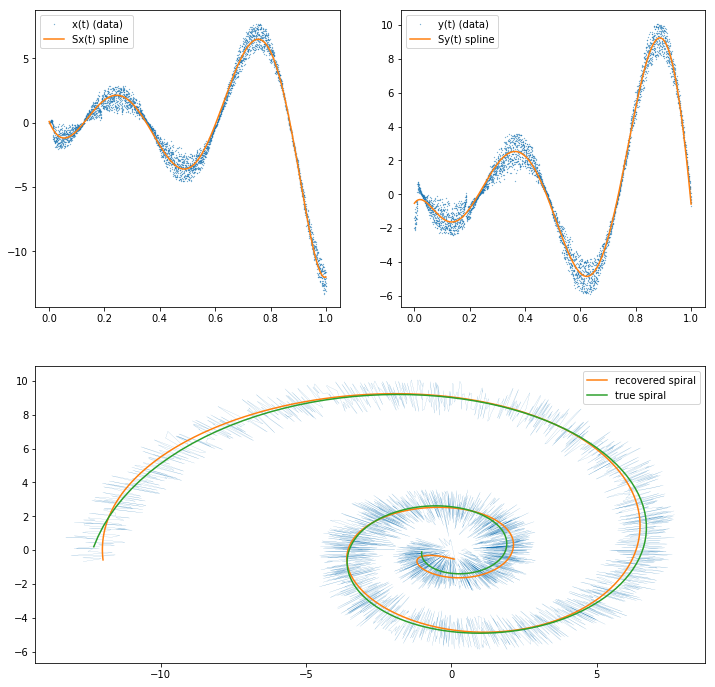

In [24]:
fig,ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
sortedMeans = means[a]
t = np.linspace(0, 1, len(result))
Sx = UnivariateSpline(t, result[:, 0], s=800, k=5)
Sy = UnivariateSpline(t, result[:, 1], s=800, k=5)

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)

ax1.plot(t, result[:,0], '.', markersize=0.5, label='x(t) (data)')
ax1.plot(t, Sx(t), label='Sx(t) spline')
ax1.legend()

ax2.plot(t, result[:,1], '.', markersize=0.5, label='y(t) (data)')
ax2.plot(t, Sy(t), label='Sy(t) spline')
ax2.legend()

t2 = np.linspace(0, 1, len(result))
ax3.plot(result[:, 0], result[:, 1], linewidth=0.1)
ax3.plot(Sx(t2), Sy(t2), label='recovered spiral')
s = [spiral1, spiral2][label]
ax3.plot(s[:,0], s[:, 1], label='true spiral')
ax3.legend()

# Conclusions

Well it's not perfect... There are many problems that could arise when dealing with actual classifications (next chapter) and in order to obtain a good fit to the original spiral, some manual fiddling of the spline smoothing parameter ($s$) was needed (though this is tied to the number / clustering of points, so finding a relation between $n_\mathrm{points}$ and $s$ may be possible).

In the next chapter, I will attempt to apply this technique in a supervised manner to a classification of one of the galaxies from the Galaxy Builder beta.
<style>
.navbutton {
    background:#000;color:white;padding:10px;border-radius:10px;
}
</style>
    
<a href="/" class="navbutton">Home</a>  <a href="chapter2.ipynb" class="navbutton">Next</a>